<script>
        var code_show=true; //true -> hide code at first
    
        function code_toggle() {
            $('div.prompt').hide(); // always hide prompt
            $('div[style*=\"border-style: dashed"\]').hide(); // hide extra comments, usually log from treasuredata
            $('div.output_stderr').parent().hide();
    
            if (code_show){
                $('div.input').hide();
            } else {
                $('div.input').show();
            }
            code_show = !code_show
        }
        $( document ).ready(code_toggle);
    </script>

In [67]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

plt.style.use("bmh")

# Introduction

## Background

On weekdays, I commute using both train and TransJakarta. Since those are public transportations, we can't expect the vehicle has enough space for all passengers (yes, I don't even mention "comfortable"). Thus, sometimes I have to wait for the next train or bus, wishing for getting space to get in. The question is, will the train/bus be spacious enough so that I could get in?

## Research Questions

How likely will I get in a bus after waiting for certain minutes?

# Assumptions and Known Limitations

- This analysis focuses on bus, not train, assuming that I don't have any other commuting options if I am already waiting at the train station. Meanwhile, if the bus doesn't come, I can use ride-hailing service.
- The survival analysis is based on Kaplan-Meier estimator

# Data Preparation

The dataset contains 1,000 observations which simulate bus waiting time, which ranges from 0 minute (I'm so lucky if I get in the bus without waiting) to 75 minutes. `observed` attribute describes whether I get in the bus or not after waiting for `wait_time` minutes.

In [75]:
from random import randint
import datetime

n = 1000 # number of observations
startdate = datetime.datetime(2018,1,1,8,0,0)
wait_time = []

for i in range(n):
    date = startdate+datetime.timedelta(minutes=randint(1,75))
    wait_time.append((date.hour-8)*60 + date.minute)

In [128]:
df = pd.DataFrame(
    data = {
        'wait_time': np.array(wait_time).T,
        'observed': np.random.binomial(n=1, p=.5, size=n)
    }
)

In [139]:
print("Dataset preview:")
df.tail(5)

Dataset preview:


,wait_time,observed
995,5,1
996,67,0
997,70,1
998,13,0
999,29,0


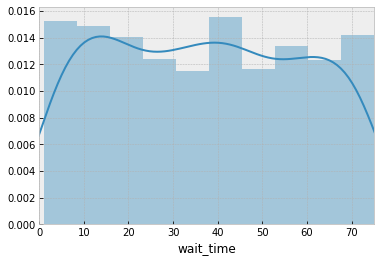

In [140]:
sns.distplot(
    df['wait_time']
)

plt.xlim(0,75);

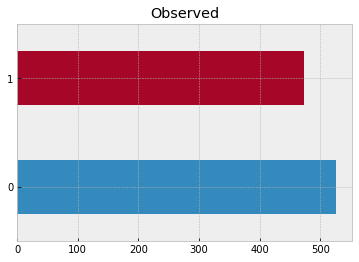

In [144]:
df['observed'].value_counts().plot.barh(title='Observed');

# Analysis

We use Kaplan-Meier estimator to calculate probability of getting a bus after waiting for *x* minutes. Wait, how does it work?

We aggregate the dataset based on the time attribute (`wait_time`), then we calculate number of `observed` events (get in bus). There are cases when we haven't observed the final result due to **censoring**: at the time of data collection, the `observed` event doesn't occur yet, e.g. after waiting for 30 minutes, I haven't got in the bus.

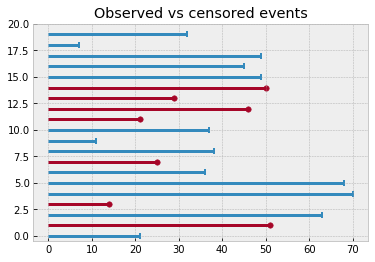

In [159]:
from lifelines.plotting import plot_lifetimes

plt.title("Observed vs censored events")
plot_lifetimes(df['wait_time'].head(20), df['observed'].head(20));

In [ ]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(durations=df['wait_time'], 
        event_observed=df['observed'])

In [134]:
from lifelines.utils import survival_table_from_events

table = survival_table_from_events(df['wait_time'], df['observed'])
table = table.merge(
    kmf.survival_function_,
    how='left',
    left_index=True,
    right_index=True
)
print(table.head(10))

          removed  observed  censored  entrance  at_risk  KM_estimate
event_at                                                             
0.0             0         0         0      1000     1000     1.000000
1.0            11         6         5         0     1000     0.994000
2.0            21        12         9         0      989     0.981939
3.0            15         6         9         0      968     0.975853
4.0            15         4        11         0      953     0.971757
5.0            13         5         8         0      938     0.966577
6.0            12         6         6         0      925     0.960307
7.0            19         9        10         0      913     0.950841
8.0             7         2         5         0      894     0.948714
9.0            14         6         8         0      887     0.942296


Median: 57 minutes


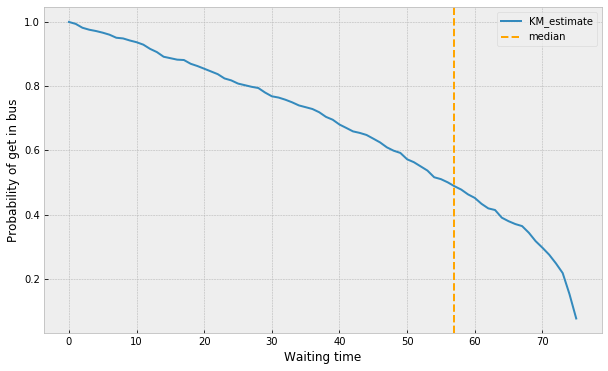

In [145]:
fig, ax = plt.subplots(figsize=(10,6))
kmf.survival_function_.plot(ax=ax)
ax.axvline(kmf.median_, linestyle='--', c='orange', label='median')

plt.xlabel("Waiting time")
plt.ylabel("Probability of get in bus")
plt.legend();

print('Median: {:.0f} minutes'.format(kmf.median_))

Based on the survival probability, I am more likely to get in the bus within 57 minutes of waiting time. If I wait longer, ...

# Results and Discussions

*describe what you find and how it can be improved*

# References

- https://jakevdp.github.io/blog/2018/09/13/waiting-time-paradox/

- https://lifelines.readthedocs.io/en/latest/Quickstart.html#kaplan-meier-and-nelson-aalen